In [1]:
using Revise, FeynmanKacParticleFilters, RCall, SpecialFunctions, Distributions, Random, DataFrames, DataFramesMeta, CSV, StatsFuns
R"library(tidyverse)"

┌ Info: Recompiling stale cache file /home/guillaume/.julia/compiled/v1.0/FeynmanKacParticleFilters/kMPoX.ji for FeynmanKacParticleFilters [b43f8e06-e683-11e8-294f-8d3ef32cb08c]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/guillaume/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/guillaume/.julia/compiled/v1.0/DataFramesMeta/2xRTO.ji for DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/guillaume/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190
┌ Warning: RCall.jl: Loading tidyverse: ggplot2
│ Loading tidyverse: tibble
│ Loading tidyverse: tidyr
│ Loading tidyverse: readr
│ Loading tidyverse: purrr
│ Loading tidyverse: dplyr
│ Conflicts with tidy packages ---------------------------------------------------
│ filter(): dplyr, stats
│ 

RObject{StrSxp}
 [1] "dplyr"     "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"  
 [7] "tidyverse" "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"     


# Data generation

The CIR process solves the following SDE:

$$
\begin{equation}
dX_t = (\delta\sigma^2-2\gamma X_t)dt + 2\sigma\sqrt{X_t}dB_t
\end{equation}
$$

with $\delta, \gamma, \sigma > 0$.

We use the function rcCIR from R package sde which returns random variables from the conditional law $X(t+Dt)|X(t)$ of the process solution of 

$$
\begin{equation}
dX_t = (\theta_1-\theta_2 X_t)dt + \theta_3\sqrt{X_t}dB_t
\end{equation}
$$

with $2\theta_1>\theta_3^2$


$$
\begin{equation}
Y_t|X_t \sim \text{Po}(X_t)
\end{equation}
$$

In [2]:
Random.seed!(1)
R"set.seed(1)"

δ = 3.
γ = 2.5
σ = 4.
Nobs = 2
dt = 0.011
# max_time = .1
# max_time = 0.001
Nsteps = 60
λ = 1
Nparts = 200

α = δ/2
β = γ/σ^2
time_grid = [k*dt for k in 0:(Nsteps-1)]
X = FeynmanKacParticleFilters.generate_CIR_trajectory(time_grid, 3, δ*1.2, γ/1.2, σ*0.7)
Y = map(λ -> rand(Poisson(λ), Nobs), X);
data = zip(time_grid, Y) |> Dict;

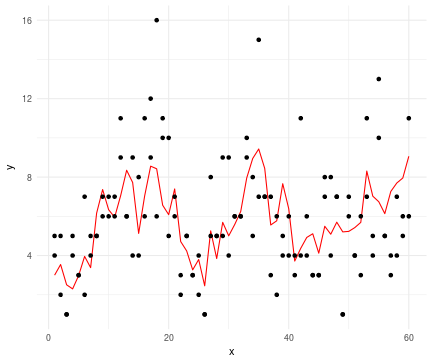

RObject{VecSxp}


In [3]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) + 
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"

# Particle filtering

In [4]:
Mt = FeynmanKacParticleFilters.create_transition_kernels_CIR(data, δ, γ, σ)
logGt = FeynmanKacParticleFilters.create_log_potential_functions_CIR(data)
RS(W) = rand(Categorical(W), length(W))

RS (generic function with 1 method)

In [5]:
pf = FeynmanKacParticleFilters.generic_particle_filtering_logweights1D(Mt, logGt, Nparts, RS)

Dict{String,Array{Float64,2}} with 3 entries:
  "X"    => [14.6109 2.15482 … 3.47396 6.7056; 1.0264 6.59856 … 7.40033 3.54713…
  "logw" => [-13.0514 -4.41633 … -4.61641 -5.14273; -9.78386 -5.4698 … -4.15063…
  "logW" => [-13.5361 -5.36393 … -5.74407 -4.66872; -10.2686 -6.41739 … -5.2782…

In [6]:
n_samples = 100
sample_from_filtering_dist = 1:Nsteps |>
    x -> map(i -> DataFrame(filter_smp = FeynmanKacParticleFilters.sample_from_filtering_distributions_logweights1D(pf, n_samples, i), time_idx = i), x) |>
    x -> vcat(x...) |>
    df -> @transform(df, time = (:time_idx .- 1) * dt)

,filter_smp,time_idx,time
,Float64,Int64,Float64
1,4.61643,1,0.0
2,3.8999,1,0.0
3,8.46569,1,0.0
4,5.29638,1,0.0
5,3.3199,1,0.0
6,5.98039,1,0.0
7,2.88655,1,0.0
8,4.12795,1,0.0
9,4.15314,1,0.0


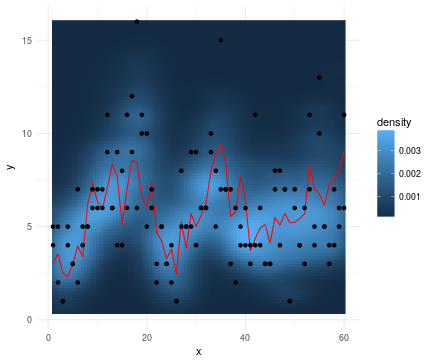

RObject{VecSxp}


In [7]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) +
    stat_density_2d(data = as_tibble($sample_from_filtering_dist), aes(x = time_idx, y = filter_smp, fill = ..density..), geom = 'raster', contour = FALSE) +
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"

Light colour -> high filtering density.
The filtering densities look reasonably close to the data and to the hidden signal.

# Particle smoothing

## Adaptive resampling

In [8]:
CIR_invariant_logdensity(X) = FeynmanKacParticleFilters.CIR_invariant_logdensity(X, δ, γ, σ)

transition_logdensity_CIR(Xtp1, Xt, Δtp1) = FeynmanKacParticleFilters.CIR_transition_logdensity(Xtp1, Xt, Δtp1, δ, γ, σ)

transition_logdensity_CIR (generic function with 1 method)

In [9]:
ps = FeynmanKacParticleFilters.two_filter_marginal_smoothing_algorithm_adaptive_resampling_logweights(Mt, logGt, Nparts, RS, transition_logdensity_CIR, CIR_invariant_logdensity)

Dict{String,Any} with 2 entries:
  "X"    => Dict(2=>[3.15912, 2.07509, 3.49901, 6.86558, 3.39714, 4.58481, 5.58…
  "logW" => [-4.74696 -7.76156 … -8.56286 -11.0777; -3.85945 -11.6809 … -3.0350…

In [10]:
n_samples = 100
sample_from_smoothing_dist = 1:(Nsteps-1) |>
    x -> map(i -> DataFrame(filter_smp = FeynmanKacParticleFilters.sample_from_smoothing_distributions_logweights(ps, n_samples, i), time_idx = i), x) |>
    x -> vcat(x...) |>
    df -> @transform(df, time = (:time_idx .- 1) * dt)

,filter_smp,time_idx,time
,Float64,Int64,Float64
1,3.81049,1,0.0
2,4.72555,1,0.0
3,6.52619,1,0.0
4,7.14363,1,0.0
5,5.83015,1,0.0
6,5.74932,1,0.0
7,5.06413,1,0.0
8,5.83413,1,0.0
9,4.94098,1,0.0


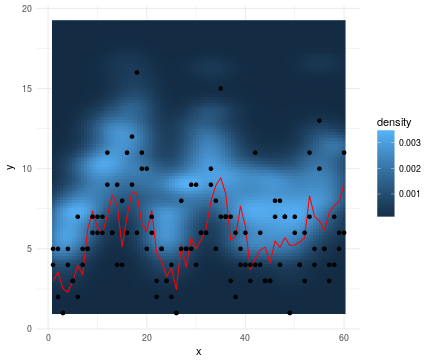

RObject{VecSxp}


In [11]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) +
    stat_density_2d(data = as_tibble($sample_from_smoothing_dist), aes(x = time_idx, y = filter_smp, fill = ..density..), geom = 'raster', contour = FALSE) +
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"

## No adaptive resampling

In [12]:
ps = FeynmanKacParticleFilters.two_filter_marginal_smoothing_algorithm_logweights(Mt, logGt, Nparts, RS, transition_logdensity_CIR, CIR_invariant_logdensity)

Dict{String,Any} with 2 entries:
  "X"    => Dict(2=>[3.13904, 8.2208, 1.97213, 4.06647, 9.31851, 1.44366, 3.313…
  "logW" => [-6.49908 -7.23822 … -5.70867 -14.077; -6.72827 -5.46426 … -11.542 …

In [13]:
n_samples = 100
sample_from_smoothing_dist = 1:(Nsteps-1) |>
    x -> map(i -> DataFrame(filter_smp = FeynmanKacParticleFilters.sample_from_smoothing_distributions_logweights(ps, n_samples, i), time_idx = i), x) |>
    x -> vcat(x...) |>
    df -> @transform(df, time = (:time_idx .- 1) * dt)

,filter_smp,time_idx,time
,Float64,Int64,Float64
1,4.88375,1,0.0
2,4.53009,1,0.0
3,4.43823,1,0.0
4,6.23446,1,0.0
5,5.71914,1,0.0
6,6.23446,1,0.0
7,5.841,1,0.0
8,7.10341,1,0.0
9,7.76306,1,0.0


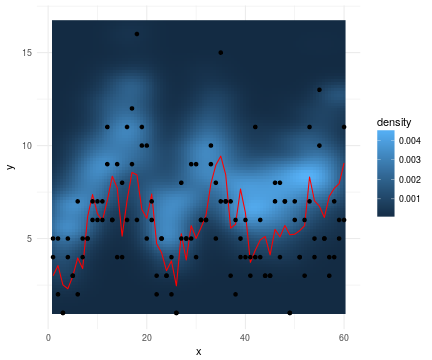

RObject{VecSxp}


In [14]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) +
    stat_density_2d(data = as_tibble($sample_from_smoothing_dist), aes(x = time_idx, y = filter_smp, fill = ..density..), geom = 'raster', contour = FALSE) +
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"

## Second version

In [15]:
backward_Mt = FeynmanKacParticleFilters.create_backward_transition_kernels_CIR(data, δ, γ, σ)

Dict{Float64,Function} with 60 entries:
  0.495 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.517 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.011 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.33  => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.297 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.561 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.484 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.022 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.418 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.341 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.528 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.242 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.055 => #Mt#8{Float64,Float64,Float64,Float64}(0.011, 3.0, 2.5, 4.0)
  0.396 => #Mt#8{Float64

In [16]:
ps = FeynmanKacParticleFilters.two_filter_marginal_smoothing_algorithm_logweightsV2(Mt, backward_Mt, logGt, logGt, Nparts, RS, transition_logdensity_CIR, CIR_invariant_logdensity)

Dict{String,Any} with 2 entries:
  "X"    => Dict(2=>[2.65256, 6.62866, 3.9003, 5.96336, 3.08675, 8.14686, 3.995…
  "logW" => [-26.3255 -12.6673 … -6.66727 -12.1952; -11.053 -4.3898 … -3.94096 …

In [17]:
n_samples = 100
sample_from_smoothing_dist = 1:(Nsteps-1) |>
    x -> map(i -> DataFrame(filter_smp = FeynmanKacParticleFilters.sample_from_smoothing_distributions_logweights(ps, n_samples, i), time_idx = i), x) |>
    x -> vcat(x...) |>
    df -> @transform(df, time = (:time_idx .- 1) * dt)

,filter_smp,time_idx,time
,Float64,Int64,Float64
1,8.1215,1,0.0
2,6.78954,1,0.0
3,4.41285,1,0.0
4,5.47035,1,0.0
5,6.54548,1,0.0
6,6.2441,1,0.0
7,4.76719,1,0.0
8,2.7368,1,0.0
9,4.76719,1,0.0


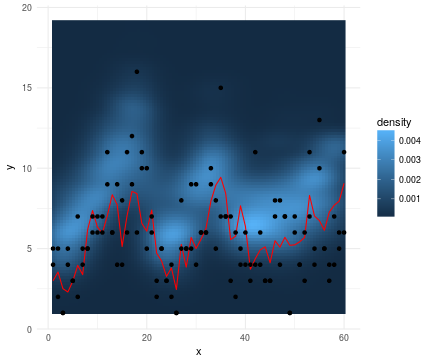

RObject{VecSxp}


In [18]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) +
    stat_density_2d(data = as_tibble($sample_from_smoothing_dist), aes(x = time_idx, y = filter_smp, fill = ..density..), geom = 'raster', contour = FALSE) +
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"

# Forward Filtering Backward Smoothing algorithm

In [21]:
ps = FeynmanKacParticleFilters.generic_FFBS_algorithm_logweights(Mt, logGt, Nparts, Nparts, RS, transition_logdensity_CIR)

Dict{String,Any} with 2 entries:
  "X"    => Dict{Any,Any}(2=>[2.20307, 3.36927, 5.5855, 8.59693, 9.47841, 6.574…
  "logW" => [-3.84794 -4.49605 … -5.67194 -4.99609; -35.6125 -4.38741 … -8.4922…

In [22]:
n_samples = 100
sample_from_smoothing_dist = 1:(Nsteps-1) |>
    x -> map(i -> DataFrame(filter_smp = FeynmanKacParticleFilters.sample_from_smoothing_distributions_logweights(ps, n_samples, i), time_idx = i), x) |>
    x -> vcat(x...) |>
    df -> @transform(df, time = (:time_idx .- 1) * dt)

,filter_smp,time_idx,time
,Float64,Int64,Float64
1,2.75661,1,0.0
2,4.91508,1,0.0
3,3.80671,1,0.0
4,3.58098,1,0.0
5,6.45663,1,0.0
6,6.58428,1,0.0
7,2.55415,1,0.0
8,4.21778,1,0.0
9,3.93119,1,0.0


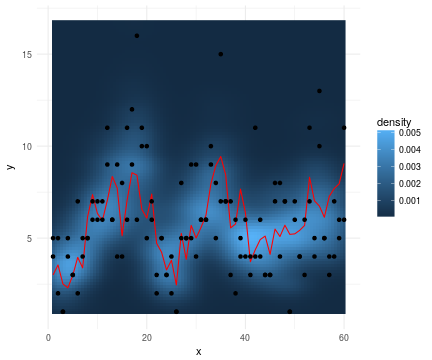

RObject{VecSxp}


In [23]:
R"tibble(y = $X) %>%
    mutate(x = seq_along(y)) %>%
    inner_join($(hcat(Y...)) %>% 
    as_tibble %>%
    gather(x, value) %>%
    mutate(x = gsub('V','',x) %>% as.numeric), by = 'x') %>%
    ggplot(aes(x = x, y = y)) +
    stat_density_2d(data = as_tibble($sample_from_smoothing_dist), aes(x = time_idx, y = filter_smp, fill = ..density..), geom = 'raster', contour = FALSE) +
    theme_minimal() + 
    geom_line(colour='red') + 
    geom_point(aes(y = value))"